# Autonomous Vehicle

A self-driving car that manuvers itself on a two-lane track. The car should recognize other cars or obstacles in its way and responds accordingly (like change the lane or stop).

### Hardware Used
- Raspberry Pi-3
- Camera
- Metal car chassis
- Motor driver
- Li-Po battery 
- Bluetooth

![alt text](Car_image.jpg)

### Car control
- Car motors are connected via 11V Li-Po battery while, Raspberry Pi is powered by a power bank.
- Signals are sent through an android app, according to which the car is driven.
- While the car moves, a Camera installed in the front of the car, takes pictures (frame rate = 8)
- Images as well as the movement of car (front, right, left etc) at the point image was taken are stored.

### Car is automated by using Deep Learning
- A track has been made to simulate the car moving on a track, and generate the training data for neural network.


<img src = "track_image1.jpg" width="500px" height="400px"/>

- The labeled images stored through the camera are taken as data, to train a convolutional neural network.

<img src="track_image2.jpg" style="float:left;width:350px;height:300px;margin-left:50px;"/>
<img src="track_image3.jpg" style="width:350px;height:300px;margin-top:0;"/>

                  image082.jpg, F                                            image153.jpg, L
               
- Below mentioned is the code to process and train the data.

In [22]:
# to fix the random feed
# in order to generate same random numbers each time
import numpy as np
np.random.seed(123)
from tensorflow import set_random_seed
set_random_seed(123) 

import pandas as pd
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, MaxPooling2D, Flatten
from keras.layers import Dropout, Convolution2D, LSTM, Merge, Reshape
from keras.layers.wrappers import TimeDistributed
from keras.models import load_model
from keras.callbacks import TensorBoard
from keras.optimizers import Adam

# Visualization of Data

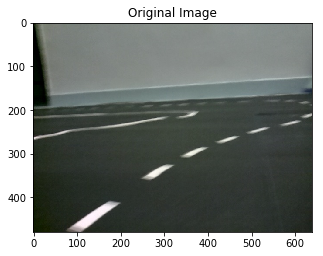

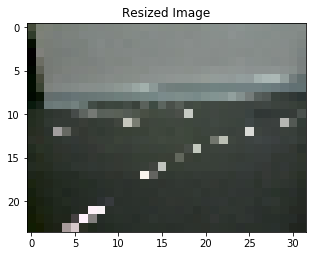

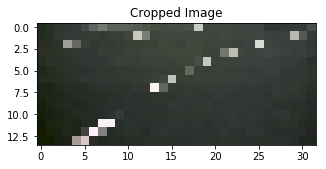

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

image = cv2.imread('image081.jpg')
resized_image = cv2.resize(image, (32, 24))
new_image = resized_image[10:,:]
# plt.subplot(3,1,1)
plt.subplots(figsize=(5,5))
plt.imshow(image,aspect='equal')
# plt.tight_layout()
plt.title('Original Image')
plt.show()

# plt.subplot(3,1,2)
plt.subplots(figsize=(5,5))
plt.imshow(resized_image,aspect=1)
plt.title('Resized Image')
plt.show()

# plt.subplot(3,1,3)
plt.subplots(figsize=(5,5))
plt.imshow(new_image,aspect=1)
plt.title('Cropped Image')
plt.show()

# Preprocessing Data
- The following code reads the data from a text file containing 14x32=448 pixels with their labels.
- Then the labels and pixel values are separated.
- pixels are reshaped into a matrix of 14x32 and normalized into the range of 0 to 1.
- y labels (F, R, L, S) are also encoded accordingly.
- Values are then split into training(85%), test(7.5%) and validation sets(7.5%).

In [20]:
# pixel size
img_x = 32
img_y = 24
img_x_start = 10

# reading training data
df = pd.read_csv('train_our_data_shift.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df = df[df[str(448)]!='S']
df = df[df[str(448)]!='s']

# dividing features and labels
X = df.drop(str(img_x*(img_y-img_x_start)), axis=1)
y = df[str(img_x*(img_y-img_x_start))]

# resizing training data
X_data = X.values.reshape(-1,448)
X_data = X_data.reshape(X_data.shape[0], 14, 32, 1)
X_data = X_data.astype('float32')
X_data /= 255

# categorizing labels
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
y_data = to_categorical(y, 3)

# split train, test and validation data
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, random_state=0, test_size=0.16)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, random_state=0, test_size=0.55)
X_check, X_val, y_check, y_val = train_test_split(X_test,y_test, random_state=0, test_size=0.97)

print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)
print("X_test shape:",X_test.shape)
print("y_test shape:",y_test.shape)
print("X_val shape:",X_val.shape)
print("y_val shape:",y_val.shape)
print("X_check shape:",X_check.shape)
print("y_check shape:",y_check.shape)

X_train shape: (12064, 14, 32, 1)
y_train shape: (12064, 3)
X_test shape: (1034, 14, 32, 1)
y_test shape: (1034, 3)
X_val shape: (1003, 14, 32, 1)
y_val shape: (1003, 3)
X_check shape: (31, 14, 32, 1)
y_check shape: (31, 3)


# Deep Learning Model

In [33]:
# creating model
model = Sequential()
 
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(14,32,1)))

model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

adam = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# training model
model.fit(X_train, y_train, batch_size=150, epochs=15, verbose=1, validation_data=(X_val,y_val))

# getting accuracy
scores = model.evaluate(X_test, y_test, verbose=0)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Train on 12064 samples, validate on 1003 samples
Epoch 1/15
12064/12064 [==============================] - 21s - loss: 0.5050 - acc: 0.8220 - val_loss: 0.3749 - val_acc: 0.8564

# Model Summary

In [32]:
print(model.summary())
model.save("29_nov_1230.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 12, 30, 32)        320       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 10, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 14, 64)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4480)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               573568    
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 387       
Total params: 592,771
Trainable params: 592,771
Non-trainable params: 0
_________________________________________________________________
None

In [46]:
model = load_model("29_nov_1230.h5")
print("Predicted Values:", np.argmax(model.predict(X_check), axis=1))
print("Ground Truth:    ", np.argmax(y_check, axis=1))

Predicted Values: [0 0 1 1 2 0 0 0 1 0 0 1 0 1 0 0 0 2 0 1 1 0 0 1 0 0 2 0 2 0 0]
Ground Truth:     [0 0 1 1 2 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 0 2 0 2 0 0]


###### Result: 3 errors
# Other Models
### 1. RNN

In [ ]:
hm_epochs = 10
n_classes = 4
batch_size = 64

chunk_size = 32
n_chunks = 14
rnn_size = 128

x = tf.placeholder('float',[None, n_chunks, chunk_size])
y = tf.placeholder('float')

def get_data():
    df = pd.read_csv('train_our_data_shift.csv')
    df.drop('Unnamed: 0',axis=1,inplace=True)

    df = df[df['448']!='S']

    X = df.drop(str(14*32), axis=1)
    y = df[str(14*32)]

    X_data = X.values.reshape(-1,448)
    X_data = X_data.reshape(X_data.shape[0], 14, 32, 1)
    X_data = X_data.astype('float32')
    X_data /= 255

    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    y_data = tf.contrib.keras.utils.to_categorical(y, 4)

    X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, random_state=0, test_size=0.3)
    X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, random_state=0, test_size=0.5)
    
    return [X_train, X_test, X_val, y_train, y_test, y_val]

def rnn_model(x):
    layer = {'weights':tf.Variable(tf.random_normal([rnn_size, n_classes])),
            'biases':tf.Variable(tf.random_normal([n_classes]))}
    
    x = tf.reshape(x, [-1, chunk_size])
    x = tf.split(x, n_chunks, 0)
    
    # single RNN layer
    lstm_cell = rnn_cell.BasicLSTMCell(rnn_size)
    rnn_outputs, final_state = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
   
    # multiple RNN layers 
    '''
    num_layers = 3

    stacked_rnn = []
    for _ in range(num_layers):
        stacked_rnn.append(tf.nn.rnn_cell.BasicLSTMCell(rnn_size, state_is_tuple=True))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells=stacked_rnn, state_is_tuple=True)
    rnn_outputs, final_state = tf.nn.static_rnn(cell, x, dtype=tf.float32)
    '''

    output = tf.add(tf.matmul(rnn_outputs[-1], layer['weights']), layer['biases'])
    
    return output

def train_model(x):
    prediction = rnn_model(x)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))

    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    [X_train, X_test, X_val, y_train, y_test, y_val] = get_data()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epochs in range(hm_epochs):
            epoch_loss = 0
            for i in range(int(X_train.shape[0]/batch_size)):
                batch_x = X_train[i*batch_size:(i+1)*batch_size]
                batch_y = y_train[i*batch_size:(i+1)*batch_size]
                
                batch_x = batch_x.reshape((batch_size, n_chunks, chunk_size))

                _, c = sess.run([optimizer, cost], feed_dict = {x: batch_x, y: batch_y})
                epoch_loss += c

            print('Epoch:', epochs+1, '/', hm_epochs, ' Loss:', epoch_loss)

        correct = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct,'float'))
        print('Accuracy: ', accuracy.eval({x: X_test.reshape((-1, n_chunks, chunk_size)), y: y_test}))
train_model(x)

# Comparison of Different RNN models
<br>
- LSTM 1 layer, Batch Size = 128 &emsp;  accuracy = 88.30%<hr>
- LSTM 1 layer, Batch Size = 256 &emsp;  accuracy = 86.90%<hr>
- LSTM 1 layer, Batch Size = 64  &emsp;&nbsp;&nbsp;   accuracy = 88.16%<hr>
- <b>LSTM 2 layer, Batch Size = 64  &emsp;&nbsp;&nbsp;   accuracy = 89.87%</b><hr>
- LSTM 3 layer, Batch Size = 64  &emsp;&nbsp;&nbsp;   accuracy = 89.09%<br>

### 2. CNN + RNN

In [ ]:
dropout = 0.8
n_classes = 4
batch_size = 128
hm_epochs = 10

x = tf.placeholder('float',[None,14,32,1])
y = tf.placeholder('float')

def get_data():
    df = pd.read_csv('train_our_data_shift.csv')
    df.drop('Unnamed: 0',axis=1,inplace=True)

    df = df[df['448']!='S']

    X = df.drop(str(14*32), axis=1)
    y = df[str(14*32)]

    X_data = X.values.reshape(-1,448)
    X_data = X_data.reshape(X_data.shape[0], 14, 32, 1)
    X_data = X_data.astype('float32')
    X_data /= 255

    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    y_data = tf.contrib.keras.utils.to_categorical(y, 4)

    X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, random_state=0, test_size=0.3)
    X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, random_state=0, test_size=0.5)
    
    return [X_train, X_test, X_val, y_train, y_test, y_val]

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def maxpool2d(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def cnn_model(x):
    weights = {'W_conv1':tf.Variable(tf.random_normal([5,5,1,32])),
               'W_conv2':tf.Variable(tf.random_normal([5,5,32,64])),
               'W_fc':tf.Variable(tf.random_normal([2048,128])),
               'out':tf.Variable(tf.random_normal([128, n_classes]))}
    
    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
              'b_conv2':tf.Variable(tf.random_normal([64])),
              'b_fc':tf.Variable(tf.random_normal([128])),
              'out':tf.Variable(tf.random_normal([n_classes]))}
        
    x = tf.reshape(x, shape=[-1,14,32,1])
        
    conv1 = conv2d(x, weights['W_conv1']) + biases['b_conv1']
    conv1 = tf.nn.relu(conv1)
    conv1 = maxpool2d(conv1)
    print("conv1 shape:",conv1.shape)

    conv2 = conv2d(conv1, weights['W_conv2']) + biases['b_conv2']
    conv2 = tf.nn.relu(conv2)
    conv2 = maxpool2d(conv2)
    print("conv2 shape:",conv2.shape)
    
    fc = tf.reshape(conv2, [-1, 2048])
    fc = tf.matmul(fc, weights['W_fc']) + biases['b_fc']
    fc = tf.nn.relu(fc)
    fc = tf.nn.dropout(fc, dropout)
    print("fc shape:",fc.shape)
    
    output = tf.matmul(fc, weights['out']) + biases['out']
    print("output shape:",output.shape)
    return output

def train_model(x):
    prediction = cnn_model(x)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))

    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    [X_train, X_test, X_val, y_train, y_test, y_val] = get_data()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epochs in range(hm_epochs):
            epoch_loss = 0
            for i in range(int(X_train.shape[0]/batch_size)):
                batch_x = X_train[i*batch_size:(i+1)*batch_size]
                batch_y = y_train[i*batch_size:(i+1)*batch_size]
                
                _, c = sess.run([optimizer, cost], feed_dict = {x: batch_x, y: batch_y})
                epoch_loss += c

            correct = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
            accuracy = tf.reduce_mean(tf.cast(correct,'float'))
            print('Epoch:', epochs+1, '/', hm_epochs, ' Loss:', epoch_loss, ' Accuracy:', accuracy.eval({x: X_val, y: y_val}))        
                
        correct = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct,'float'))
        print('Accuracy: ', accuracy.eval({x: X_test, y: y_test}))
train_model(x)

#### Accuracy : 88%

# Conclusion


- This project was intended to build a working model of an autonomous car which was capable of manoeuvring itself on a self-made car track.
- The main aim was to use Deep Learning to train the car with the images of track taken during training phase and deploying the trained model to run the car autonomously.
- We compared and contrasted various deep learning models used on our data, generated during training. The various models were tuned using various hyperparameters to get the efficient output.
- During the course of this project, we were able to test and implement a number of theories and architectures of deep learning, and select the one, best suited for our requirement.

![alt text](best_model.png)